## Assignment

In this assignment, you'll continue working with the [U.S. Education Dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/home) from Kaggle. The data gives detailed state level information on the several facets of the state of education on annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You should access the data from the Thinkful database. Below are the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'useducation'<br>

Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoints to the data. You should provide your answers to the following questions after you handled the missing values.

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

Say, we want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

1. Create a new score variable from the weighted averages of all score variables in the datasets. **Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!**.
2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?
3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?
4. What is the correlation between the overall score variable and the 1st principal component? 
5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

### Instantiate and Quick Clean

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
%matplotlib inline

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation', con=engine)

engine.dispose()

In [3]:
unique_states = list(df.STATE.unique())

In [4]:
appended_data = []

for state in unique_states:
    state_df = df[df.STATE == state].copy().sort_values('YEAR').interpolate(limit_direction='both')
    appended_data.append(state_df)

filled_df = pd.concat(appended_data)

In [5]:
filled_df.dropna(inplace=True) 

In [6]:
df = filled_df

### 1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!

In [7]:
g4_avg = (df.AVG_MATH_4_SCORE + df.AVG_READING_4_SCORE)/2
g8_avg = (df.AVG_MATH_8_SCORE + df.AVG_READING_8_SCORE)/2

In [8]:
g4_count = df.GRADES_4_G
g8_count = df.GRADES_8_G
overall_count = g4_count + g8_count

In [9]:
df['OVERALL_SCORE'] = ((g4_count * g4_avg) + (g8_count * g8_avg)) / overall_count

In [10]:
df.OVERALL_SCORE

0       232.204803
52      233.367062
104     234.015532
157     234.889785
209     235.106342
           ...    
1146    255.707927
1197    255.834463
1248    255.764406
808     253.745430
1490    251.726455
Name: OVERALL_SCORE, Length: 1331, dtype: float64

### 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [11]:
df.iloc[:, 8:13].head()

,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
0,2653798.0,1481703.0,735036.0,237222.0,174053.0
52,2833433.0,1564558.0,794146.0,237222.0,204207.0
104,3103266.0,1697593.0,826442.0,306977.0,231508.0
157,3353363.0,1851700.0,888983.0,326956.0,243365.0
209,3572283.0,1987018.0,935115.0,322883.0,286699.0


In [12]:
for col in df.columns[8:13]:
    print(col)
    print('correlation is', df.OVERALL_SCORE.corr(df[col]))

TOTAL_EXPENDITURE
correlation is 0.1269550784320594
INSTRUCTION_EXPENDITURE
correlation is 0.13310514220800196
SUPPORT_SERVICES_EXPENDITURE
correlation is 0.1342736412760859
OTHER_EXPENDITURE
correlation is 0.0625966689884925
CAPITAL_OUTLAY_EXPENDITURE
correlation is 0.06053607031846737


Alternative method:

In [13]:
corr_cols = ['OVERALL_SCORE']
for item in list(df.columns[9:13]):
    corr_cols.append(item)
df[corr_cols].corr()

,OVERALL_SCORE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
OVERALL_SCORE,1.000000,0.133105,0.134274,0.062597,0.060536
INSTRUCTION_EXPENDITURE,0.133105,1.000000,0.976228,0.908494,0.893354
SUPPORT_SERVICES_EXPENDITURE,0.134274,0.976228,1.000000,0.953215,0.915092
OTHER_EXPENDITURE,0.062597,0.908494,0.953215,1.000000,0.920356
CAPITAL_OUTLAY_EXPENDITURE,0.060536,0.893354,0.915092,0.920356,1.000000


Appears that SUPPORT_SERVICES_EXPENDITURE has the highest correlation, but just barely edges out INSTRUCTION_EXPENDITURE.

### 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

**Long way** first - for understanding!

In [33]:
X = scale(df[list(df.columns)[9:13]], with_mean=True, with_std=True)
Xt = X.T
Cx = np.cov(Xt)
print(Cx)

[[1.00075188 0.97696231 0.90917703 0.89402619]
 [0.97696231 1.00075188 0.95393168 0.91578002]
 [0.90917703 0.95393168 1.00075188 0.92104785]
 [0.89402619 0.91578002 0.92104785 1.00075188]]


In [34]:
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

In [35]:
eig_vec_cov.T

array([[-0.49937176, -0.50816374, -0.49980633, -0.49253537],
       [-0.52942634,  0.79076289, -0.30567037,  0.03110339],
       [-0.58427108, -0.33165228,  0.2257729 ,  0.70545068],
       [ 0.35911405, -0.08043893, -0.77832246,  0.50870504]])

In [36]:
print(eig_val_cov/sum(eig_val_cov))

[0.94595623 0.00348233 0.0311108  0.01945063]


It would appear the first component explains approximately 94.6% of the variance.

**Quick Way**

In [30]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)
print(sklearn_pca.explained_variance_ratio_)
print(sklearn_pca.components_)
print(Y_sklearn[:, 0])
Y = eig_vec_cov[:, 0].T.dot(Xt)
print(Y)

[0.94595623 0.0311108  0.01945063 0.00348233]
[[ 0.49937176  0.50816374  0.49980633  0.49253537]
 [-0.58427108 -0.33165228  0.2257729   0.70545068]
 [ 0.35911405 -0.08043893 -0.77832246  0.50870504]
 [ 0.52942634 -0.79076289  0.30567037 -0.03110339]]
[-1.00721751 -0.98088322 -0.89073659 ...  0.28438321  0.35150789
  0.35150789]
[-0.50931762 -0.53565191 -0.62579853 ... -1.80091834 -1.86804301
 -1.86804301]


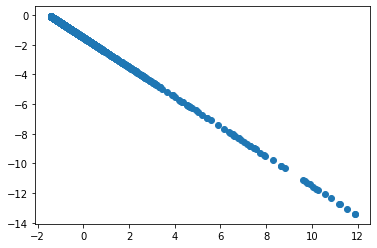

In [32]:
plt.plot(Y_sklearn[:, 0], Y, 'o')

Same, just ordered differently (highest to lowest)

### 4. What is the correlation between the overall score variable and the 1st principal component?

In [18]:
P = eig_vec_cov[:, 0]
comp1 = P.T.dot(X.T)
sk_comp1 = Y_sklearn[:, 0]

In [19]:
df['comp1'] = comp1
df['sk_comp1'] = sk_comp1

In [20]:
df.OVERALL_SCORE.corr(df.comp1)

-0.1006599555442414

In [21]:
df.OVERALL_SCORE.corr(df.sk_comp1)

0.10065995554424141

Still not very highly correlated.

In [22]:
corr_cols.append('comp1')
corr_cols.append('sk_comp1')
df[corr_cols].corr()

,OVERALL_SCORE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,comp1,sk_comp1
OVERALL_SCORE,1.000000,0.133105,0.134274,0.062597,0.060536,-0.100660,0.100660
INSTRUCTION_EXPENDITURE,0.133105,1.000000,0.976228,0.908494,0.893354,-0.971381,0.971381
SUPPORT_SERVICES_EXPENDITURE,0.134274,0.976228,1.000000,0.953215,0.915092,-0.988483,0.988483
OTHER_EXPENDITURE,0.062597,0.908494,0.953215,1.000000,0.920356,-0.972226,0.972226
CAPITAL_OUTLAY_EXPENDITURE,0.060536,0.893354,0.915092,0.920356,1.000000,-0.958083,0.958083
comp1,-0.100660,-0.971381,-0.988483,-0.972226,-0.958083,1.000000,-1.000000
sk_comp1,0.100660,0.971381,0.988483,0.972226,0.958083,-1.000000,1.000000


### 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

Because the correlation between these variables either way is not very high, I probably wouldn't use either of them as features for a model where the target variable is overall score. However, if I were forced to choose one way or the other - both ways present advantages and disadvantages. The non-PCA way has variables that are higher correlated with the outcome variable, however with this brings the problem of higher dimensionality which will likely cause problems in our model. The PCA component way may be better even though it is not as correlated because it only brings one dimension into the fray, which is much simpler than 4! However, with PCA we must consider how correlated the variables are with one another, and in this case the expense variables are all highly correlated with one another which generally is not good for PCA. It is likely best to simply use one of the expenditure variables (that is most correlated with our outcome) to help explain the data.